# Formality Linear Probes

This notebook uses Linear Probes (LP) to analyze the location(s) in a large language model (Phi-4) at which formality level can be linearly decoded.

## Resources

* Dataset: https://huggingface.co/datasets/osyvokon/pavlick-formality-scores
* LLM: https://huggingface.co/microsoft/phi-4

In [1]:
import pandas as pd
import transformers
from llm_style.formality_dataset import FormalityDataset

In [2]:
dataset = FormalityDataset.from_contrastive_samples(
    pd.read_csv("../data/handcoded_formality_examples.csv").to_dict(orient="records"),
    return_float_labels=True,
)

In [3]:
pipeline = transformers.pipeline(
    "text-generation",
    model="microsoft/phi-4",
    model_kwargs={"torch_dtype": "auto"},
    device_map="auto",
)


Loading checkpoint shards:   0%|          | 0/6 [00:00<?, ?it/s]

Device set to use mps


In [4]:
# How to do inference:


# messages = [
#     {
#         "role": "system",
#         "content": "You are a medieval knight and must provide explanations to modern people.",
#     },
#     {"role": "user", "content": "How should I explain the Internet?"},
# ]

# outputs = pipeline(messages, max_new_tokens=1)
# print(outputs[0]["generated_text"][-1])


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Get device for computation
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Extract texts and labels from the dataset
texts = [sample["text"] for sample in dataset]
labels = [sample["label"] for sample in dataset]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Define a function to extract features from text
def extract_features(model, tokenizer, texts, layer_idx):
    # Move model to the correct device if not already there
    model_device = next(model.parameters()).device
    if model_device != device:
        model = model.to(device)

    features = []
    batch_size = 16  # Adjust based on your GPU/memory

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Tokenize the texts
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
        inputs = {k: v.to(device) for k, v in inputs.items()}

        # Get model outputs with no gradient computation
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)

        # Extract hidden states from the specified layer
        # For phi-4 model, access the proper hidden states format
        if hasattr(outputs, 'hidden_states'):
            hidden_states = outputs.hidden_states[layer_idx]
        else:
            # If hidden_states is a tuple, access it directly
            hidden_states = outputs[2][layer_idx]
        hidden_states = hidden_states.to(torch.float32)

        # Average across the token dimension to get a fixed-size representation
        batch_features = hidden_states.mean(dim=1)
        batch_features_cpu = batch_features.cpu().numpy()
        features.append(batch_features_cpu)

    return np.vstack(features)

# Define a function to perform linear probing for a specified layer
def linear_probe_layer(model, tokenizer, X_train, y_train, X_test, y_test, layer_idx):
    # Extract features for training and testing sets
    train_features = extract_features(model, tokenizer, X_train, layer_idx)
    test_features = extract_features(model, tokenizer, X_test, layer_idx)

    # Convert string labels to binary (1 for formal, 0 for informal)
    y_train_binary = y_train
    y_test_binary = y_test

    # Train a logistic regression classifier
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(train_features, y_train_binary)

    # Evaluate on training and testing data
    train_preds = clf.predict(train_features)
    test_preds = clf.predict(test_features)

    train_acc = accuracy_score(y_train_binary, train_preds)
    test_acc = accuracy_score(y_test_binary, test_preds)

    return {
        "layer": layer_idx,
        "train_accuracy": train_acc,
        "test_accuracy": test_acc
    }

# Define a function to perform linear probing across all layers
def linear_probe_all_layers(model, tokenizer, X_train, y_train, X_test, y_test):
    results = []
    num_layers = model.config.num_hidden_layers + 1  # +1 for the embedding layer

    for layer_idx in range(num_layers):
        print(f"Probing layer {layer_idx}/{num_layers-1}...")
        result = linear_probe_layer(model, tokenizer, X_train, y_train, X_test, y_test, layer_idx)
        results.append(result)
        print(f"Layer {layer_idx}: Train acc = {result['train_accuracy']:.4f}, Test acc = {result['test_accuracy']:.4f}")

    return results


Using device: mps


In [7]:
# Perform linear probing across all layers
probe_results = linear_probe_all_layers(pipeline.model, pipeline.tokenizer, X_train, y_train, X_test, y_test)

Probing layer 0/40...
Layer 0: Train acc = 0.5625, Test acc = 0.2500
Probing layer 1/40...
Layer 1: Train acc = 1.0000, Test acc = 1.0000
Probing layer 2/40...
Layer 2: Train acc = 1.0000, Test acc = 1.0000
Probing layer 3/40...
Layer 3: Train acc = 1.0000, Test acc = 1.0000
Probing layer 4/40...
Layer 4: Train acc = 1.0000, Test acc = 1.0000
Probing layer 5/40...
Layer 5: Train acc = 1.0000, Test acc = 1.0000
Probing layer 6/40...
Layer 6: Train acc = 1.0000, Test acc = 1.0000
Probing layer 7/40...
Layer 7: Train acc = 1.0000, Test acc = 1.0000
Probing layer 8/40...
Layer 8: Train acc = 1.0000, Test acc = 1.0000
Probing layer 9/40...
Layer 9: Train acc = 1.0000, Test acc = 1.0000
Probing layer 10/40...
Layer 10: Train acc = 1.0000, Test acc = 1.0000
Probing layer 11/40...
Layer 11: Train acc = 1.0000, Test acc = 1.0000
Probing layer 12/40...
Layer 12: Train acc = 1.0000, Test acc = 1.0000
Probing layer 13/40...
Layer 13: Train acc = 1.0000, Test acc = 1.0000
Probing layer 14/40...
Lay

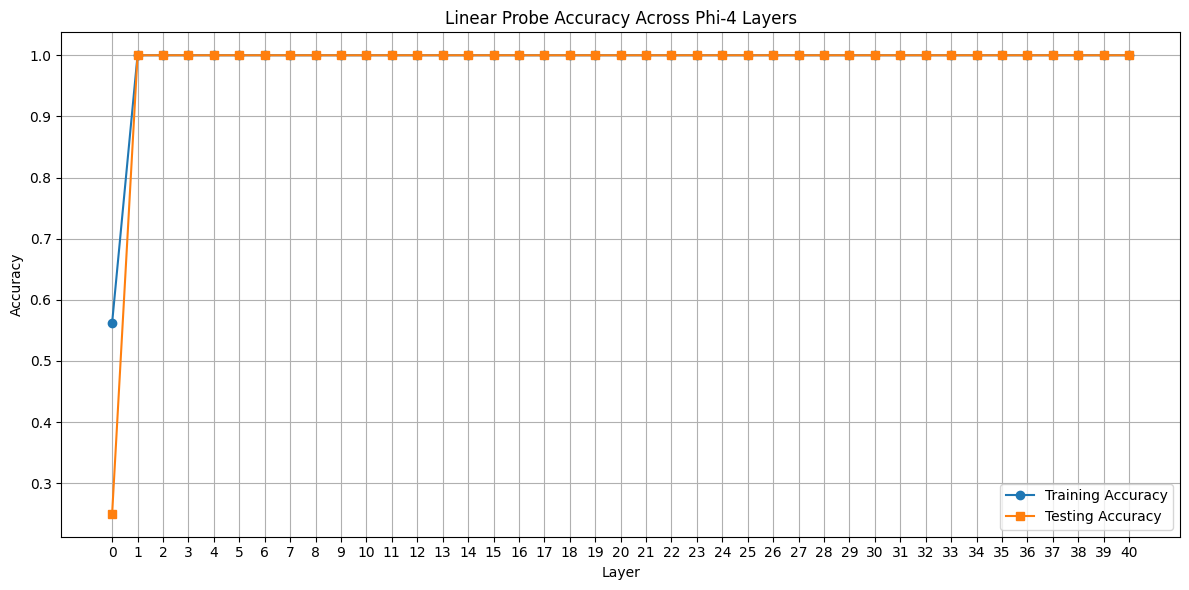

In [8]:
# Extract results for plotting
layers = [result["layer"] for result in probe_results]
train_accs = [result["train_accuracy"] for result in probe_results]
test_accs = [result["test_accuracy"] for result in probe_results]

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(layers, train_accs, marker='o', label='Training Accuracy')
plt.plot(layers, test_accs, marker='s', label='Testing Accuracy')
plt.title('Linear Probe Accuracy Across Phi-4 Layers')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.xticks(layers)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Analysis of Results

The plot above shows how well we can predict formality from different layers of the Phi-4 model. Here are some key observations:

1. **Early vs Late Layers**: Compare how accuracy changes from early layers (close to input) to later layers (close to output).
2. **Training vs Testing Performance**: The gap between training and testing accuracy indicates how well the probe generalizes.
3. **Peak Performance**: The layer with the highest testing accuracy indicates where formality information is most linearly accessible.

This analysis helps us understand how and where the model encodes stylistic properties like formality.

In [9]:
# Find the layer with the best test accuracy
best_layer_idx = np.argmax(test_accs)
best_layer = layers[best_layer_idx]
best_accuracy = test_accs[best_layer_idx]

print(f"Best performance at layer {best_layer} with test accuracy: {best_accuracy:.4f}")

Best performance at layer 1 with test accuracy: 1.0000
